In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#download MNIST Dataset
train_data_MNIST=datasets.MNIST(
    root='Data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data_MNIST=datasets.MNIST(
    root='Data',
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15932644.96it/s]


Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 491861.68it/s]


Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4455871.55it/s]


Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4733050.63it/s]

Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw



In [ ]:
from torch.utils.data import DataLoader
#dataloader
traindata_loader=DataLoader(
    train_data_MNIST,
    batch_size=32,
    shuffle=True
)
testdata_loader=DataLoader(
    test_data_MNIST,
    batch_size=32,
    shuffle=False
)


In [ ]:
xtrain_MNIST=[]
ytrain_MNIST=[]
for (img,lbl) in train_data_MNIST:
  xtrain_MNIST.append(img)
  ytrain_MNIST.append(lbl)
xtrain_MNIST=torch.stack(xtrain_MNIST)
ytrain_MNIST=torch.tensor(ytrain_MNIST)


In [ ]:
xtrain_MNIST.shape

torch.Size([60000, 1, 28, 28])

<ipython-input-6-cf07eb366c74>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(xtrain_MNIST[2].T.transpose(0,1))


10


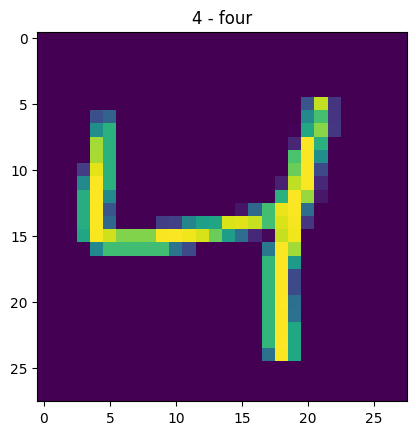

In [ ]:
label=train_data_MNIST.classes
plt.imshow(xtrain_MNIST[2].T.transpose(0,1))
plt.title(label[ytrain_MNIST[2]])
print(len(label))

In [ ]:
#grayscale CNN

class grayScaleCNN(nn.Module):
  def __init__(self):
    super(grayScaleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10) # 10 classes for MNIST

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = x.view(-1, 64 * 7 * 7)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
grayScaleCNNModel = grayScaleCNN()


In [ ]:
class spacedLearning():
    def __init__(self, n_nn=20, benchmarkAccuracy=95):
        self.n_nn = n_nn
        self.benchmarkAccuracy = benchmarkAccuracy

    def fit(self, X, y, pred, epochsF):
        self.models = []
        i = 1
        for _ in range(self.n_nn):
            x_samp, y_samp = self._bootstraped(X, y)
            # Pass the bootstrapped samples to _train_test
            model_copy = self._train_test(x_samp, y_samp, i, epochsF)
            with torch.inference_mode():
              pred = model_copy(x_samp)
            pred = torch.argmax(pred, dim=1)
            currAcc = self.accuracy_fn(y_samp, pred)
            print(f'Model {i} accuracy : {currAcc}')
            if (_>0) and (currAcc >= self.benchmarkAccuracy):
                self.models.append([model_copy, currAcc])
            if self.benchmarkAccuracy < currAcc:
                self.benchmarkAccuracy = currAcc
            i+=1

    def _train_test(self, X, y, curNN, epochs): # Add y as argument
        model_copy = grayScaleCNNModel.to(device)
        optim = torch.optim.SGD(params=model_copy.parameters(), lr=0.05)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            # Convert X and y to tensors and move to device within the loop
            X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)
            model_copy.train()
            ypred = model_copy(X)
            loss = loss_fn(ypred, y)
            print(f'loss={loss} epoch={epoch} current NN={curNN}')
            optim.zero_grad()
            loss.backward()
            optim.step()
        return model_copy

    def accuracy_fn(self, y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
        acc = (correct / (len(y_pred))) * 100
        return acc

    def _bootstraped(self, X, y):
        n_samps = X.shape[0]
        size = n_samps // 10
        idx = np.random.choice(n_samps, size, replace=True)
        return X[idx], y[idx]

    def _voting(self, predictions):
        if isinstance(predictions[0], np.ndarray):
            return np.mean(predictions, axis=0)
        else:
            return np.bincount(predictions).argmax()

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        predictions = []
        for model in self.models:
            model[0].eval()
            with torch.no_grad():
                ypred = model[0](X)*(model[1]/50)
                ypred = torch.argmax(ypred, dim=1).cpu().numpy()
                predictions.append(ypred)

        ensemble_predictions = [self._voting(p) for p in zip(*predictions)]
        return ensemble_predictions

In [ ]:
spacedLearningMNISTModel=spacedLearning(n_nn = 20, benchmarkAccuracy = 95)

In [ ]:
import time
start = time.time()
spacedLearningMNISTModel.fit(xtrain_MNIST.to(device), ytrain_MNIST.to(device), train_data_MNIST, 50)
stop = time.time()
print(f"Training time: {stop - start}s")

<ipython-input-78-ce0f2348ad2c>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y = torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)


loss=2.301966667175293 epoch=0 current NN=1
loss=2.2985823154449463 epoch=1 current NN=1
loss=2.2953286170959473 epoch=2 current NN=1
loss=2.292158603668213 epoch=3 current NN=1
loss=2.2890243530273438 epoch=4 current NN=1
loss=2.285792589187622 epoch=5 current NN=1
loss=2.282400608062744 epoch=6 current NN=1
loss=2.278857469558716 epoch=7 current NN=1
loss=2.2751238346099854 epoch=8 current NN=1
loss=2.271239995956421 epoch=9 current NN=1
loss=2.267242908477783 epoch=10 current NN=1
loss=2.2630929946899414 epoch=11 current NN=1
loss=2.2587621212005615 epoch=12 current NN=1
loss=2.254234790802002 epoch=13 current NN=1
loss=2.2494800090789795 epoch=14 current NN=1
loss=2.24446964263916 epoch=15 current NN=1
loss=2.2391574382781982 epoch=16 current NN=1
loss=2.2335097789764404 epoch=17 current NN=1
loss=2.2275006771087646 epoch=18 current NN=1
loss=2.2210686206817627 epoch=19 current NN=1
loss=2.214179754257202 epoch=20 current NN=1
loss=2.206784963607788 epoch=21 current NN=1
loss=2.198

In [ ]:
print(len(spacedLearningMNISTModel.models))

6


In [ ]:
samples=[]
labels=[]
pred=[]
for sample,label in test_data_MNIST:
  samples.append(sample)
  labels.append(label)
samples=torch.stack(samples)
samples=samples.to(device)
labels=torch.tensor(labels)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / (len(y_pred))) * 100
    return acc

In [ ]:
pred=spacedLearningMNISTModel.predict(samples)
pred=torch.tensor(pred)

<ipython-input-78-ce0f2348ad2c>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)


In [ ]:
accuracy_fn(pred.to(device),torch.tensor(labels).to(device))

<ipython-input-101-241a51d7f901>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy_fn(pred.to(device),torch.tensor(labels).to(device))


96.73